In [1]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import scipy
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cross_validation import StratifiedKFold
%matplotlib inline

In [2]:
train_data = pickle.load(open("072716_COMBINED_DATA_TRAIN.p","rb"))

In [3]:
nonDataCols = ['page_id','page_is_ep','article_id', 'days_since_touch']
colsToExclude = []
train_data = train_data.dropna(axis=0)
train_data['exLink_count'] = train_data['exLink_count'] / train_data['page_len']
train_data['pl_count'] = train_data['pl_count'] / train_data['page_len']
classes = train_data['page_is_ep'].as_matrix()
page_ids = train_data['page_id']
train_data = train_data.drop(nonDataCols,axis=1)
features = train_data.columns

In [22]:
X_array = scipy.sparse.csr_matrix(train_data.values).toarray()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_array, classes, test_size=0.2)

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [25]:
param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }
evallist  = [(dtest,'eval'), (dtrain,'train')]
plst = param.items()

In [26]:
num_round = 10
bst = xgb.train(plst, dtrain, num_round, evallist)

[0]	eval-error:0.075444	train-error:0.073699
[1]	eval-error:0.072027	train-error:0.069576
[2]	eval-error:0.071172	train-error:0.068893
[3]	eval-error:0.072796	train-error:0.069533
[4]	eval-error:0.072027	train-error:0.069149
[5]	eval-error:0.072710	train-error:0.069063
[6]	eval-error:0.070745	train-error:0.068252
[7]	eval-error:0.071001	train-error:0.067675
[8]	eval-error:0.070147	train-error:0.067098
[9]	eval-error:0.069207	train-error:0.066393


In [27]:
ypred = bst.predict(dtest)

In [28]:
# roc curve
num_points = 101
thresholds = np.linspace(1., 0., num_points)
tpr = []
fpr = []
auc = 0
for i, t in enumerate(thresholds):
    ypredclass = ypred > t
    tpr.append(sum((y_test == 1) * (ypredclass == 1))/sum(y_test == 1))
    fpr.append(sum((y_test == 0) * (ypredclass == 1))/sum(y_test == 0))
    if i > 0:
        auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])
print(auc)

0.894198419824


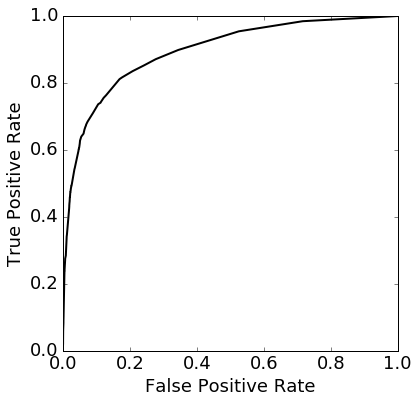

In [29]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 18})
plt.plot(fpr, tpr, 'k-', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [30]:
# let's look at the effect of number of rounds of training
test_rounds = np.unique(np.logspace(0, 2, 10, dtype=int))
auc_array = []
for num_round in test_rounds:
    bst = xgb.train(plst, dtrain, num_round, evallist )
    ypred = bst.predict(dtest)
    # do you smell what the roc is cookin' jabroni?
    num_points = 101
    thresholds = np.linspace(1., 0., num_points)
    tpr = []
    fpr = []
    auc = 0
    for i, t in enumerate(thresholds):
        ypredclass = ypred > t
        tpr.append(sum((y_test == 1) * (ypredclass == 1))/sum(y_test == 1))
        fpr.append(sum((y_test == 0) * (ypredclass == 1))/sum(y_test == 0))
        if i > 0:
            auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])
    auc_array.append(auc)

[0]	eval-error:0.075444	train-error:0.073699
[0]	eval-error:0.075444	train-error:0.073699
[1]	eval-error:0.072027	train-error:0.069576
[0]	eval-error:0.075444	train-error:0.073699
[1]	eval-error:0.072027	train-error:0.069576
[2]	eval-error:0.071172	train-error:0.068893
[3]	eval-error:0.072796	train-error:0.069533
[0]	eval-error:0.075444	train-error:0.073699
[1]	eval-error:0.072027	train-error:0.069576
[2]	eval-error:0.071172	train-error:0.068893
[3]	eval-error:0.072796	train-error:0.069533
[4]	eval-error:0.072027	train-error:0.069149
[5]	eval-error:0.072710	train-error:0.069063
[6]	eval-error:0.070745	train-error:0.068252
[0]	eval-error:0.075444	train-error:0.073699
[1]	eval-error:0.072027	train-error:0.069576
[2]	eval-error:0.071172	train-error:0.068893
[3]	eval-error:0.072796	train-error:0.069533
[4]	eval-error:0.072027	train-error:0.069149
[5]	eval-error:0.072710	train-error:0.069063
[6]	eval-error:0.070745	train-error:0.068252
[7]	eval-error:0.071001	train-error:0.067675
[8]	eval-e

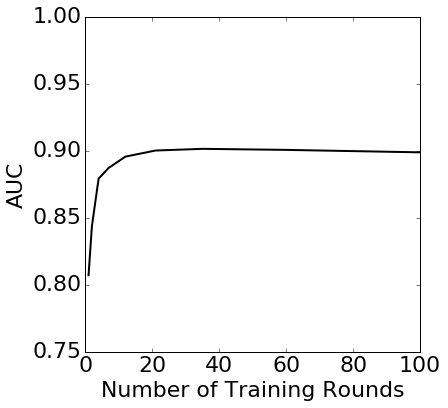

In [32]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.plot(np.array(test_rounds), auc_array, 'k-', linewidth=2)
plt.ylim([.75, 1])
plt.xlabel('Number of Training Rounds')
plt.ylabel('AUC')

In [33]:
# stratified k-fold validation
skf = StratifiedKFold(classes, n_folds=10, shuffle=True)

In [34]:
num_round = 10
kfold_auc_array = []
i = 0
for train_index, test_index in skf:
    dtrain = xgb.DMatrix(X_array[train_index], label=classes[train_index])
    dtest = xgb.DMatrix(X_array[test_index], label=classes[test_index])
    bst = xgb.train(plst, dtrain, num_round, evallist)
    ypred = bst.predict(dtest)
    # roc curve
    num_points = 1001
    thresholds = np.linspace(1., 0., num_points)
    tpr = []
    fpr = []
    auc = 0
    for i, t in enumerate(thresholds):
        ypredclass = ypred > t
        tpr.append(sum((classes[test_index] == 1) * (ypredclass == 1))/sum(classes[test_index] == 1))
        fpr.append(sum((classes[test_index] == 0) * (ypredclass == 1))/sum(classes[test_index] == 0))
        if i > 0:
            auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])
    kfold_auc_array.append(auc)
    i = i + 1

[0]	eval-error:0.075444	train-error:0.073870
[1]	eval-error:0.070574	train-error:0.069555
[2]	eval-error:0.069805	train-error:0.069555
[3]	eval-error:0.071001	train-error:0.069875
[4]	eval-error:0.070660	train-error:0.068743
[5]	eval-error:0.070062	train-error:0.068273
[6]	eval-error:0.069976	train-error:0.067910
[7]	eval-error:0.068524	train-error:0.067632
[8]	eval-error:0.069293	train-error:0.066756
[9]	eval-error:0.067327	train-error:0.067013
[0]	eval-error:0.074932	train-error:0.073528
[1]	eval-error:0.069634	train-error:0.070046
[2]	eval-error:0.069036	train-error:0.069512
[3]	eval-error:0.069549	train-error:0.069897
[4]	eval-error:0.069378	train-error:0.069598
[5]	eval-error:0.069207	train-error:0.069170
[6]	eval-error:0.068951	train-error:0.069128
[7]	eval-error:0.069207	train-error:0.069384
[8]	eval-error:0.068609	train-error:0.068999
[9]	eval-error:0.068524	train-error:0.068786
[0]	eval-error:0.075273	train-error:0.073699
[1]	eval-error:0.070062	train-error:0.069256
[2]	eval-e

In [35]:
np.mean(kfold_auc_array)

0.89241260464367611

In [36]:
importance = bst.get_fscore(fmap='')

In [41]:
importance

{'f0': 4,
 'f1': 2,
 'f110': 1,
 'f1219': 1,
 'f137': 1,
 'f148': 1,
 'f15': 1,
 'f1533': 1,
 'f1553': 1,
 'f1554': 1,
 'f2': 6,
 'f20': 3,
 'f262': 1,
 'f337': 1,
 'f374': 1,
 'f634': 1,
 'f788': 1,
 'f87': 1}

In [91]:
# let's try just these features in importance and see what happens
#limit_train_data = train_data[list(features[[0, 1, 2, 15, 20, 87, 110, 137, 148, 262, 337, 374, 634, 788, \
#                                            1219, 1533, 1553, 1554]])]
#limit_train_data = train_data[list(features[[0, 1, 2, 20]])]
limit_train_data = train_data[list(features[2::])]

limit_classes = classes
limit_features = limit_train_data.columns

In [92]:
limit_X_array = scipy.sparse.csr_matrix(limit_train_data.values).toarray()

In [93]:
limit_X_train, limit_X_test, limit_y_train, limit_y_test = train_test_split(limit_X_array, \
                                                                            limit_classes, test_size=0.2)

In [94]:
limit_dtrain = xgb.DMatrix(limit_X_train, label=limit_y_train)
limit_dtest = xgb.DMatrix(limit_X_test, label=limit_y_test)

In [95]:
limit_param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }
limit_evallist  = [(limit_dtest,'eval'), (limit_dtrain,'train')]
limit_plst = limit_param.items()

In [96]:
num_round = 10
limit_bst = xgb.train(limit_plst, limit_dtrain, num_round, limit_evallist)

[0]	eval-error:0.075188	train-error:0.072545
[1]	eval-error:0.071856	train-error:0.068999
[2]	eval-error:0.071856	train-error:0.068999
[3]	eval-error:0.072283	train-error:0.069192
[4]	eval-error:0.072539	train-error:0.069939
[5]	eval-error:0.070574	train-error:0.069298
[6]	eval-error:0.071941	train-error:0.069341
[7]	eval-error:0.072710	train-error:0.068957
[8]	eval-error:0.071941	train-error:0.068914
[9]	eval-error:0.070403	train-error:0.067739


In [97]:
limit_ypred = limit_bst.predict(limit_dtest)

In [98]:
# roc curve
num_points = 101
thresholds = np.linspace(1., 0., num_points)
tpr = []
fpr = []
auc = 0
for i, t in enumerate(thresholds):
    limit_ypredclass = limit_ypred > t
    tpr.append(sum((limit_y_test == 1) * (limit_ypredclass == 1))/sum(limit_y_test == 1))
    fpr.append(sum((limit_y_test == 0) * (limit_ypredclass == 1))/sum(limit_y_test == 0))
    if i > 0:
        auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])
print(auc)

0.886742009876


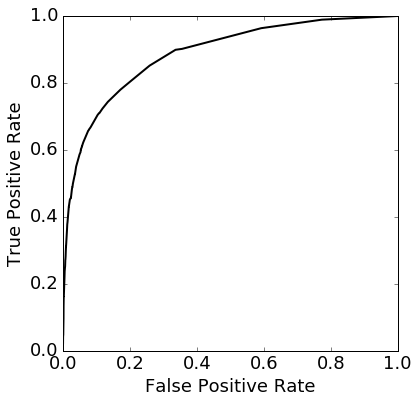

In [99]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 18})
plt.plot(fpr, tpr, 'k-', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [75]:
limit_features

Index(['page_len', 'revisionslastyear', 'pageviews', 'ratio'], dtype='object')

In [85]:
limit_importance = limit_bst.get_fscore()

In [86]:
limit_importance

{'f10': 1,
 'f11': 2,
 'f116': 1,
 'f12': 1,
 'f13': 1,
 'f140': 1,
 'f145': 1,
 'f15': 1,
 'f1529': 1,
 'f1538': 1,
 'f1543': 1,
 'f1550': 1,
 'f1551': 1,
 'f17': 6,
 'f216': 1,
 'f224': 1,
 'f251': 1,
 'f330': 1,
 'f429': 1,
 'f631': 1,
 'f8': 1,
 'f84': 1,
 'f94': 1,
 'f96': 1}

In [89]:
inds = [int(item[1::]) for item in limit_importance.keys()]
features[inds]

Index(['electromagnet', 'mostRecentWithinWeek', 'gene', 'pca_bad', 'c_albums',
       'footbal', 'c_21st', 'frac_database', 'c_award', 'frac_entertainment',
       'frac_popular', 'pca_egypt', 'pca_non_us_sports', 'cemeteri',
       'monasteri', 'frac_library', 'exLink_count', 'obama',
       'pca_sad_olympians', 'walt_disney_pictures_films', 'portray',
       'pca_reality_tv', 'diet', 'frac_social'],
      dtype='object')

In [24]:
# vary eta
eta_array = np.linspace(.1, 2, 20)
eta_limit_auc_array = []
for eta in eta_array:
    limit_param = {'bst:max_depth':2, 'bst:eta':eta, 'silent':1, 'objective':'binary:logistic' }
    limit_evallist  = [(limit_dtest,'eval'), (limit_dtrain,'train')]
    limit_plst = limit_param.items()
    num_round = 10
    limit_bst = xgb.train(limit_plst, limit_dtrain, num_round, limit_evallist)
    limit_ypred = limit_bst.predict(limit_dtest)
    # roc curve
    num_points = 101
    thresholds = np.linspace(1., 0., num_points)
    tpr = []
    fpr = []
    auc = 0
    for i, t in enumerate(thresholds):
        limit_ypredclass = limit_ypred > t
        tpr.append(sum((limit_y_test == 1) * (limit_ypredclass == 1))/sum(limit_y_test == 1))
        fpr.append(sum((limit_y_test == 0) * (limit_ypredclass == 1))/sum(limit_y_test == 0))
        if i > 0:
            auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])
    eta_limit_auc_array.append(auc)

[0]	eval-error:0.075957	train-error:0.072353
[1]	eval-error:0.075359	train-error:0.071541
[2]	eval-error:0.075359	train-error:0.071541
[3]	eval-error:0.075359	train-error:0.071541
[4]	eval-error:0.075188	train-error:0.071371
[5]	eval-error:0.075188	train-error:0.071371
[6]	eval-error:0.073565	train-error:0.069982
[7]	eval-error:0.073565	train-error:0.069982
[8]	eval-error:0.073052	train-error:0.069918
[9]	eval-error:0.073137	train-error:0.069961
[0]	eval-error:0.075957	train-error:0.072353
[1]	eval-error:0.075530	train-error:0.071456
[2]	eval-error:0.075530	train-error:0.071456
[3]	eval-error:0.073992	train-error:0.071200
[4]	eval-error:0.072881	train-error:0.069918
[5]	eval-error:0.071856	train-error:0.069576
[6]	eval-error:0.072967	train-error:0.069384
[7]	eval-error:0.071001	train-error:0.069405
[8]	eval-error:0.072454	train-error:0.069341
[9]	eval-error:0.071429	train-error:0.069533
[0]	eval-error:0.075957	train-error:0.072353
[1]	eval-error:0.072198	train-error:0.069939
[2]	eval-e

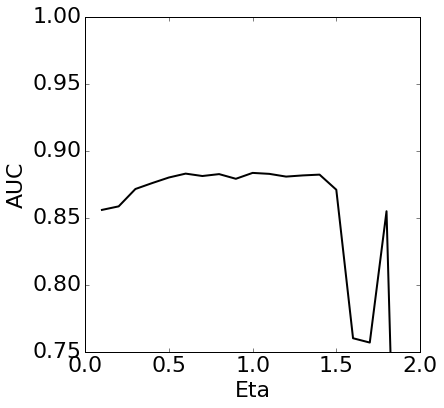

In [25]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.plot(eta_array, eta_limit_auc_array, 'k-', linewidth=2)
plt.ylim([.75, 1])
plt.xlabel('Eta')
plt.ylabel('AUC')

In [104]:
# vary tree max depth
# vary eta
depth_array = np.linspace(1, 10, 10, dtype=int)
depth_limit_auc_array = []
for depth in depth_array:
    limit_param = {'bst:max_depth':depth, 'bst:eta':1., 'silent':1, 'objective':'binary:logistic' }
    limit_evallist  = [(limit_dtest,'eval'), (limit_dtrain,'train')]
    limit_plst = limit_param.items()
    num_round = 10
    limit_bst = xgb.train(limit_plst, limit_dtrain, num_round, limit_evallist)
    limit_ypred = limit_bst.predict(limit_dtest)
    # roc curve
    num_points = 101
    thresholds = np.linspace(1., 0., num_points)
    tpr = []
    fpr = []
    auc = 0
    for i, t in enumerate(thresholds):
        limit_ypredclass = limit_ypred > t
        tpr.append(sum((limit_y_test == 1) * (limit_ypredclass == 1))/sum(limit_y_test == 1))
        fpr.append(sum((limit_y_test == 0) * (limit_ypredclass == 1))/sum(limit_y_test == 0))
        if i > 0:
            auc = auc + (tpr[-1] + tpr[-2])/2. * (fpr[-1] - fpr[-2])
    depth_limit_auc_array.append(auc)

[0]	eval-error:0.079631	train-error:0.077587
[1]	eval-error:0.079631	train-error:0.077587
[2]	eval-error:0.076811	train-error:0.074917
[3]	eval-error:0.076811	train-error:0.074917
[4]	eval-error:0.076213	train-error:0.074105
[5]	eval-error:0.071258	train-error:0.069213
[6]	eval-error:0.071258	train-error:0.069320
[7]	eval-error:0.071258	train-error:0.069320
[8]	eval-error:0.071685	train-error:0.069491
[9]	eval-error:0.072368	train-error:0.071285
[0]	eval-error:0.075188	train-error:0.072545
[1]	eval-error:0.071856	train-error:0.068999
[2]	eval-error:0.071856	train-error:0.068999
[3]	eval-error:0.072283	train-error:0.069192
[4]	eval-error:0.072539	train-error:0.069939
[5]	eval-error:0.070574	train-error:0.069298
[6]	eval-error:0.071941	train-error:0.069341
[7]	eval-error:0.072710	train-error:0.068957
[8]	eval-error:0.071941	train-error:0.068914
[9]	eval-error:0.070403	train-error:0.067739
[0]	eval-error:0.071941	train-error:0.069213
[1]	eval-error:0.071856	train-error:0.069128
[2]	eval-e

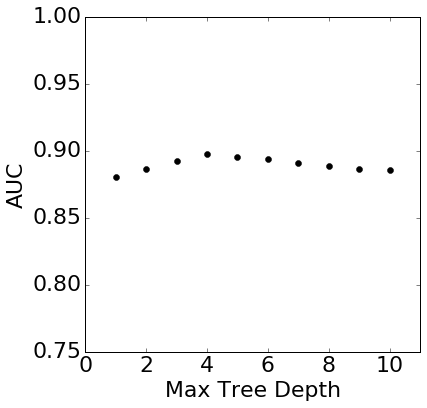

In [105]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.plot(depth_array, depth_limit_auc_array, 'ko', linewidth=2)
plt.ylim([.75, 1])
plt.xlim([0, 11])
plt.xlabel('Max Tree Depth')
plt.ylabel('AUC')